In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

from sif import compute_word_frequencies, compute_sif_weights, compute_sif_embeddings, remove_pc_sif
from similarity import min_max_scale, calculate_similarity
from glove import download_glove, load_glove_vectors
from prepare_data import preprocess_text

/Users/yegor/Desktop/学校/S24/CompLing/SIF_minmax/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/yegor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yegor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ds = load_dataset("mteb/stsbenchmark-sts")
glove_vectors = load_glove_vectors("../data/raw/glove.6B.300d.txt")

In [3]:
df_sts = ds["train"].data.to_pandas()

In [4]:
df_sts['sentence1'] = preprocess_text(df_sts['sentence1'])
df_sts['sentence2'] = preprocess_text(df_sts['sentence2'])

In [5]:
len(df_sts["sentence1"]), len(df_sts["sentence2"])

(5749, 5749)

In [6]:
sentences = df_sts[['sentence1', 'sentence2']].values.flatten().tolist()

In [7]:
word_freq = compute_word_frequencies(sentences)

In [8]:
len(word_freq)

10860

In [9]:
len(sentences), len(word_freq), len(df_sts)

(11498, 10860, 5749)

In [10]:
sif_weights = compute_sif_weights(word_freq)

In [11]:
len(sif_weights)

10860

In [12]:
corpus = [df_sts['sentence1'].tolist(), df_sts['sentence2'].tolist()]

In [13]:
len(corpus[0]), len(corpus[1])

(5749, 5749)

In [14]:
embeddings1 = compute_sif_embeddings(corpus[0], glove_vectors, sif_weights)
embeddings2 = compute_sif_embeddings(corpus[1], glove_vectors, sif_weights)

In [15]:
len(embeddings1), len(embeddings2)

(5749, 5749)

In [16]:
embeddings1_pc_removed = remove_pc_sif(embeddings1)
embeddings2_pc_removed = remove_pc_sif(embeddings2)

In [17]:
len(embeddings1_pc_removed), len(embeddings2_pc_removed)

(5749, 5749)

In [18]:
from typing import List


def calculate_similarity(embeddings1: List[np.ndarray], embeddings2: List[np.ndarray]) -> List[float]:
    similarities = []
    for i in range(len(embeddings1)):
        sim = np.dot(embeddings1[i], embeddings2[i])
        similarities.append(sim)
    return min_max_scale(similarities)

similarities = calculate_similarity(embeddings1_pc_removed, embeddings2_pc_removed)
# Apply min-max scaling to similarities
scaled_similarities = minmax_scale(similarities)

# Add calculated similarities to the dataframe
df_sts['calculated_similarity'] = scaled_similarities

In [19]:
df_sts

,split,genre,dataset,year,sid,score,sentence1,sentence2,calculated_similarity
0,train,main-captions,MSRvid,2012test,0001,5.00,"[plane, taking]","[air, plane, taking]",0.956410
1,train,main-captions,MSRvid,2012test,0004,3.80,"[man, playing, large, flute]","[man, playing, flute]",0.938606
2,train,main-captions,MSRvid,2012test,0005,3.80,"[man, spreading, shreded, cheese, pizza]","[man, spreading, shredded, cheese, uncooked, p...",0.594706
3,train,main-captions,MSRvid,2012test,0006,2.60,"[three, men, playing, chess]","[two, men, playing, chess]",0.999975
4,train,main-captions,MSRvid,2012test,0009,4.25,"[man, playing, cello]","[man, seated, playing, cello]",0.966322
...,...,...,...,...,...,...,...,...,...
5744,train,main-news,headlines,2016,1456,0.00,"[severe, gales, storm, clodagh, hits, britain]","[merkel, pledges, nato, solidarity, latvia]",0.167924
5745,train,main-news,headlines,2016,1465,0.00,"[dozens, egyptians, hostages, taken, libyan, t...","[egyptian, boat, crash, death, toll, rises, bo...",0.355758
5746,train,main-news,headlines,2016,1466,0.00,"[president, heading, bahrain]","[president, xi, china, continue, help, fight, ...",0.254602
5747,train,main-news,headlines,2016,1470,0.00,"[china, india, vow, bilateral, ties]","[china, scrambles, reassure, jittery, stock, t...",0.326875


Pearson correlation between actual scores and calculated similarities: 0.5648092841007839
Spearman correlation between actual scores and calculated similarities: 0.5492536528287979


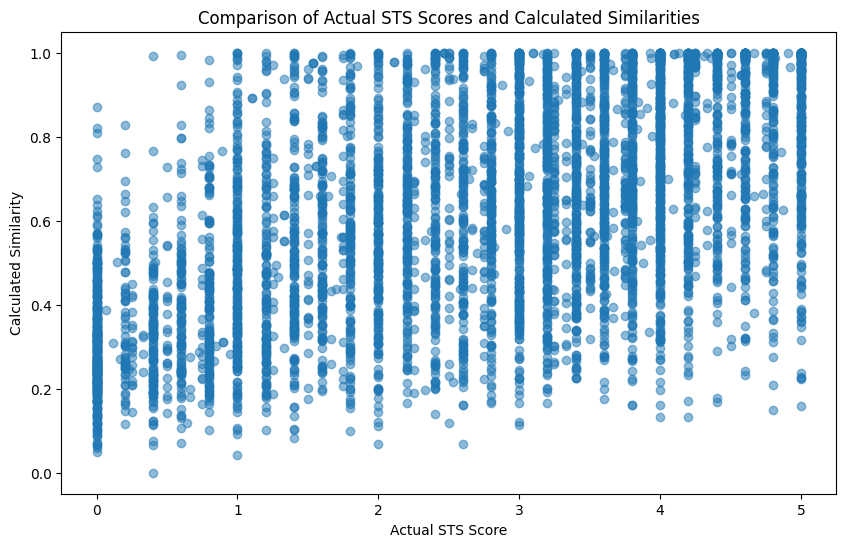

In [20]:
correlation = np.corrcoef(df_sts['score'], df_sts['calculated_similarity'])[0, 1]
print(f'Pearson correlation between actual scores and calculated similarities: {correlation}')

# Calculate Spearman correlation
from scipy import stats
spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['calculated_similarity'])
print(f'Spearman correlation between actual scores and calculated similarities: {spearman_corr}')

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.scatter(df_sts['score'], df_sts['calculated_similarity'], alpha=0.5)
plt.xlabel('Actual STS Score')
plt.ylabel('Calculated Similarity')
plt.title('Comparison of Actual STS Scores and Calculated Similarities')
plt.show()

In [21]:
df_sts['sentence1'] = df_sts['sentence1'].apply(' '.join)
df_sts['sentence2'] = df_sts['sentence2'].apply(' '.join)

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings1 = model.encode(df_sts['sentence1'].tolist())
embeddings2 = model.encode(df_sts['sentence2'].tolist())

sbert_similarities = [cosine_similarity(embeddings1[i].reshape(1, -1), 
                                        embeddings2[i].reshape(1, -1))[0][0] 
                      for i in range(len(df_sts))]

sbert_correlation = np.corrcoef(df_sts['score'], sbert_similarities)[0, 1]
print(f'SentenceTransformer Correlation: {sbert_correlation}')

SentenceTransformer Correlation: 0.8169475668582626


In [23]:
df_sts['sbert_similarity'] = sbert_similarities

sbert_pearson_corr = np.corrcoef(df_sts['score'], df_sts['sbert_similarity'])[0, 1]
sbert_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['sbert_similarity'])

sif_pearson_corr = np.corrcoef(df_sts['score'], df_sts['calculated_similarity'])[0, 1]
sif_spearman_corr, _ = stats.spearmanr(df_sts['score'], df_sts['calculated_similarity'])

print(f'SentenceTransformer Pearson Correlation: {sbert_pearson_corr}')
print(f'SentenceTransformer Spearman Correlation: {sbert_spearman_corr}')
print(f'SIF Pearson Correlation: {sif_pearson_corr}')
print(f'SIF Spearman Correlation: {sif_spearman_corr}')

SentenceTransformer Pearson Correlation: 0.8169475668582626
SentenceTransformer Spearman Correlation: 0.7852622328191703
SIF Pearson Correlation: 0.5648092841007839
SIF Spearman Correlation: 0.5492536528287979


In [24]:
df_sts

,split,genre,dataset,year,sid,score,sentence1,sentence2,calculated_similarity,sbert_similarity
0,train,main-captions,MSRvid,2012test,0001,5.00,plane taking,air plane taking,0.956410,0.914385
1,train,main-captions,MSRvid,2012test,0004,3.80,man playing large flute,man playing flute,0.938606,0.891910
2,train,main-captions,MSRvid,2012test,0005,3.80,man spreading shreded cheese pizza,man spreading shredded cheese uncooked pizza,0.594706,0.864864
3,train,main-captions,MSRvid,2012test,0006,2.60,three men playing chess,two men playing chess,0.999975,0.759767
4,train,main-captions,MSRvid,2012test,0009,4.25,man playing cello,man seated playing cello,0.966322,0.914014
...,...,...,...,...,...,...,...,...,...,...
5744,train,main-news,headlines,2016,1456,0.00,severe gales storm clodagh hits britain,merkel pledges nato solidarity latvia,0.167924,0.046905
5745,train,main-news,headlines,2016,1465,0.00,dozens egyptians hostages taken libyan terrori...,egyptian boat crash death toll rises bodies fo...,0.355758,0.323372
5746,train,main-news,headlines,2016,1466,0.00,president heading bahrain,president xi china continue help fight ebola,0.254602,0.060961
5747,train,main-news,headlines,2016,1470,0.00,china india vow bilateral ties,china scrambles reassure jittery stock traders,0.326875,0.299494


In [ ]:
"""similarities = [cosine_similarity(embeddings1_pc_removed[i].reshape(1, -1), 
                                  embeddings2_pc_removed[i].reshape(1, -1))[0][0] 
                for i in range(len(df_sts))]"""